# **Signal Simulation Framework**

## **1. Introduction**

### **1.0 Assessment Description**

Quantitative research in finance relies heavily on the analysis of historical market data to evaluate the performance of trading strategies before live deployment. However, raw market data frequently contains **noise, missing values, and inconsistent quotes**, which can distort strategy performance if not properly handled. Moreover, naive simulations that assume **perfect trade execution** often lead to **overstated and unrealistic returns**.

This assessment presents a **modular Python framework** developed to simulate trading activity under more realistic market conditions. The framework emphasizes **data integrity, execution realism, and analytical reproducibility**, providing a foundation for evaluating signal-driven trading strategies with statistical rigor.

---

### **1.2 Framework Overview**

The framework is composed of four main components:

#### 1. **Data Validation**
- Cleans and aligns quote and signal datasets.  
- Detects and removes common data issues such as **inverted spreads**, **null entries**, and **extreme outliers**.

#### 2. **Signal-Based Simulation**
- Executes trading signals using a **latency-aware fill engine**.  
- Tracks order types (open/close), executed prices, slippage, and PnL.  
- Incorporates **execution delay** to better reflect real-world trading latency.

#### 3. **Performance Metrics and Logging**
- Generates detailed **execution logs** for each simulated trade.  
- Computes essential performance metrics including:  
  - Total trade count  
  - Gross and Net PnL  
  - Average trade PnL  
  - Slippage  
  - Maximum drawdown

#### 4. **Framework Extensibility**
- Supports flexible configuration of simulation parameters such as **latency**, **signal thresholds**, and **execution models**.  

- Implements a **probabilistic execution model** that simulates **realistic fill uncertainty** using random draws based on **execution probability**, derived from **price aggressiveness** and the **relative bid–ask spread**.  

- The **relative spread** is calculated as the normalized difference between the best ask and bid prices, allowing the model to remain consistent across assets with different price scales.   

---

### **1.3 Purpose and Contribution**

This framework serves as a **lightweight yet realistic research tool** for quantitative analysts and developers.  
It enables:
- Rapid testing and validation of trading signals.  
- Insight into market impact.  
- Transparent reporting of results with reproducible performance analytics.

By integrating careful data validation with realistic execution modeling, the project bridges the gap between **theoretical signal research** and **practical trading implementation**.

---

## **2. Project Flow**

![Flow chart](Project_Flowchart.png)

### **2.0 Folder Structure**

---
### **2.1 Data Validation Step**

#### **Signals data validation**

1. Timestamps Must Be Valid & Comparable<br>
    - Signal and quote data both contain a timestamp column. Time alignment is crucial since signals must map to market quotes at the correct moment.<br>
    - All timestamps should be convertible into datetime objects.<br>
    - If formatting issues (e.g., commas in fractional seconds) exist, they are corrected.<br>

2. No Null Values<br>
    - Missing values in signals would invalidate the trading logic. In trading, incomplete data can cause incorrect signals → better to discard such rows.<br>
    - Rows with NaN are dropped.<br>

3. Timestamp Alignment Between Signals and Quotes<br>
    - Each signal must have a corresponding quote at the same timestamp. Because generating an order requires price information, which is included in the quotes.<br>
    - Any signals not aligned with quotes are removed.<br>


#### **Quotes data validation**

1. Timestamps Must Be Valid<br>
    - Same conversion as signals.<br>

2. No Duplicate Rows<br>
    - Duplicates bias spread/volume statistics and can double-count liquidity.<br>
    - Duplicate rows are dropped.<br>

- **Assumption**: <br>
Each timestamp should have a single unique bid/ask record, as the data is sampled at 1-second precision.<br>

3. Timestamps Should Be Strictly Increasing.<br>
    - Market data is sequential.<br>
    - After removing duplicates, if the timestamps are still not increasing, sort the data based on the timestamp.<br>
    - Ensures chronological integrity for time-series analysis and backtesting.<br>

4. No Null Values<br>
    - Quote data should always contain valid bid/ask prices and volumes.<br>
    - Nulls imply incomplete snapshots → invalid for trading simulations.<br>
    - Dropped rows with NaN.<br>

5. Bid-Ask Relationship Must Hold bid_price <= ask_price always.<br>
    - A market with bid > ask indicates corrupted or inverted order book data.<br>
    - Removed rows violating this.<br>

6. Spread Should Be Reasonable<br>
    - Extremely wide spreads often indicate market anomalies, bad ticks, or illiquidity.<br>
    - Rows flagged with `spread_flag = 1` for downstream analysis.<br>

    - Spread defined as:
$$
\text{Spread}_{\text{relative}} = \frac{\text{ask\_price} - \text{bid\_price}}{\text{mid\_price}}
$$

- **Assumption**: <br>
A spread is considered abnormal if it exceeds the mean by more than k times the standard deviation.<br>
$$
\text{spread\_threshold} = \text{mean}_{\text{spread}} + k \times \text{std}_{\text{spread}}
$$


7. Volumes Must Be Positive<br>
    - bid_qty > 0 and ask_qty > 0.<br>
    - Orders with non-positive volume do not exist in real markets → they indicate bad data.<br>
    - Dropped rows with zero/negative volumes.<br>
    
---


### **2.2 Signal Integration Step**


1. Threshold-Based Discretization (Decision Rule)<br>
    - The trading system converts continuous model outputs into discrete trading actions using a threshold function.<br>
    - This converts noisy continuous signals into actionable decisions: by converting categorical actions (“Buy”, “Sell”, “Hold”) into numerical values (+1, −1, 0)<br>
    - Action defined as:<br>
Action =  
{  
 **Buy**, if s > +θ  
 **Sell**, if s < −θ  
 **Hold**, otherwise  
}<br>

    where, <br>
    - s = signal strength  
    - θ = strength threshold

- **Assumption:**<br>
Small signal fluctuations near zero do not carry strong predictive power, so they are treated as noise (Hold).


2. Categorical Encoding for Downstream Simulation<br>
    - Converting categorical actions (“Buy”, “Sell”, “Hold”) into numerical values (+1, −1, 0) facilitates quantitative modeling, backtesting, and simulation.<br>



---

### **2.3 Order Generation Step**

This step models order execution behavior in a simplified yet realistic way, translating a **signal** into actionable trading orders based on current market conditions and position state.

1. A trading signal represents directional intent:
    - **+1 → Buy bias**
    - **−1 → Sell bias**
    - **0 → Hold / No trade**

2. The function `order_generator()` transforms this abstract intent into specific executable orders — determining whether to:
    - Open a new long or short position.
    - Close an existing position.
    - Flip the position (close one side and open the opposite).

3. **Position flipping logic**:
    - If the net position is already long and another Buy signal arrives, it adds to the long position.  
    - If the net position is short and a Buy signal arrives, it first closes the short position before opening a new long.  
    - The same logic applies symmetrically for Sell signals.

4. **Order Pricing**:
    - **Buy Orders:** Sent at the **best ask price**, consuming existing sell-side liquidity (*taker-style execution*).  
    - **Sell Orders:** Sent at the **best bid price**, consuming existing buy-side liquidity (*taker-style execution*).


**Assumptions:**

- **Position symmetry:** Long and short positions are perfectly symmetrical (1 long = −1 short in net exposure).  
- **Latency:** Orders are created instantly upon signal arrival.
- **Close-First Position Rule:**  
   The simulator always closes existing positions before opening new ones in the opposite direction,  
   ensuring clean transitions and no overlapping long and short exposures.


---

### **2.4 Exchange Simulation**

The `simulation()` function models a **signal-driven trading process** that mimics live market dynamics by introducing:

- **Fixed latency** between order submission and execution, 
- **Probabilistic order fills** based on price aggressiveness and spread penalty.
- **Position and PnL tracking** for both realized and unrealized performance.

It iterates through timestamped quote data, and evaluates whether received orders would have executed in a realistic exchange environment.


#### Core Assumptions

1. **Fixed Latency**  
   Each order experiences a constant **1-second delay** between submission and execution.  
   That is, an order sent at time *t* is matched against the market snapshot at *t + 1 s*.

2. **Market Stability**  
   The quote at *t + 1 s* is assumed to represent actual market conditions when the order is executed.

3. **Execution is Probabilistic**  
   Orders are not guaranteed to fill. Execution depends on:
   - **Price aggressiveness** relative to market price.  
   - **Spread-based penalty** under wide-spread conditions.  
   - **Random draw** that determines whether the order executes.  
   Together, these create a **stochastic fill model** that introduces realistic execution uncertainty.


#### **(a) Price Aggressiveness**

Measures how favorable the trader’s order price is compared to the current market price.  
Higher aggressiveness increases execution probability.

For each order side, aggressiveness is scaled using coefficients *(ca, cb)* and a minimum floor *(m = min_price_aggressiveness)*:

$$
\text{price\_aggressiveness} =
\begin{cases}
\displaystyle
\frac{((1 - m)\,p_{sent}) + (p_{bid}\,((m \cdot c_b) - 1))}{p_{bid}\,(c_b - 1)}, & \text{for sell-side orders} \\\\
\displaystyle
\frac{((1 - m)\,p_{sent}) + (p_{ask}\,((m \cdot c_a) - 1))}{p_{ask}\,(c_a - 1)}, & \text{for buy-side orders}
\end{cases}
$$

- **More aggressive (market-taking)** → higher value → higher fill chance.  
- **More passive** → lower value → lower fill probability.  
- Result is **clipped to [0, 1]** to ensure normalized scale.


#### **(b) Spread Penalty**

Wide spreads indicate **low liquidity** or **volatile** conditions.  
A multiplicative penalty (α) reduces fill probability under these conditions:

$$
P_{exec,final} = \alpha \times P_{exec,base}
$$

where  

$$
\alpha =
\begin{cases}
1.0, & \text{for normal (liquid) spreads} \\\\
\text{spread\_penalty\_factor}, & \text{for wide (illiquid) spreads (spread\_flag = 1)}
\end{cases}
$$

This models reduced match probability during stressed or unstable markets.


#### **(c) Probabilistic Fill Decision**

The final execution probability is:

$$
P_{exec} = \alpha \times \text{price\_aggressiveness}
$$

A **uniform random draw** determines whether the order is filled:

$$
\text{rand\_val} \sim U(0, 1) \\
\text{Order is filled if } \text{rand\_val} < P_{exec}.
$$

- Introduces **stochastic uncertainty** — even highly aggressive orders may occasionally fail.  
- Ensures execution outcomes are probabilistic, not deterministic.


#### **(d) Behavior Summary**

- **Buy signals (1):** Orders sent at **ask price** (*taker-style*).  
- **Sell signals (-1):** Orders sent at **bid price** (*taker-style*).  
- **Hold signals (0):** No order generated.  
- Orders are evaluated using the **next timestamp (t + 1 s)** to simulate latency.  
- **No queuing:** Each signal is processed independently.  
- Fill decisions depend on:
  - `price_aggressiveness`  
  - `spread_penalty_factor`  
  - **random draw (rand_val)**  
- **PnL** is updated dynamically using both **realized** and **unrealized** components via `pnl_obj.update_pnl()`.


#### **Simplifying Assumptions**

- Execution probability depends **only** on price aggressiveness and spread penalty.  
- **Randomness** determines final fill outcome, capturing market uncertainty.  
- **Spread penalty** simulates reduced execution under wide spreads.  
- **Latency = 1 second** ensures deterministic timing for each order event.  
- **No queue priority or partial-fill modeling:** Each signal triggers an atomic decision — filled or not filled.
- **Order Cancelling:** Orders that are not filled will be cancelled immediately.
---

### **2.5 Execution Modeling and Price Aggressiveness Derivation**

#### **Derivation of Price Aggressiveness Formula**

The goal is to design a function that translates the **order price** relative to the **market price**
into a normalized *aggressiveness score* between **0 and 1**.


#### **Intuitive Relationship**

- **Sell-side orders:** Compared against the **best bid** price ($p_{bid}$).  
  - When $p_{sent} = p_{bid}$ → the order is fully aggressive (high fill chance).  
  - When $p_{sent}$ moves **above** $p_{bid}$ → the order becomes less attractive (lower fill chance).

- **Buy-side orders:** Compared against the **best ask** price ($p_{ask}$).  
  - When $p_{sent} = p_{ask}$ → fully aggressive.  
  - When $p_{sent}$ drops **below** $p_{ask}$ → aggressiveness decreases.

To limit the region where aggressiveness meaningfully changes,  
scaling constants $c_a$ (for sells) and $c_b$ (for buys) define the valid executable range:

$$
p_{sent} \in [p_{bid}, \; c_a \times p_{bid}] \quad \text{(sell side)}
$$

$$
p_{sent} \in [c_b \times p_{ask}, \; p_{ask}] \quad \text{(buy side)}
$$

Within these bounds:

- **Aggressiveness = 1** → at the best quote (fully market-taking).  
- **Aggressiveness = m** → at the boundary (least aggressive but still valid).  
- Beyond these bounds → aggressiveness is fixed at 0 (non-executable).

#### **Linear Relationship Design**

Aggressiveness is modeled as a **linear interpolation** between two price levels:

| Condition | Price | Target Aggressiveness |
|------------|--------|-----------------------|
| Most aggressive | $p_{sent} = p_{bid}$ | $1$ |
| Least aggressive | $p_{sent} = c_b \times p_{bid}$ | $m$ |


Simplified linear mapping gives :

$$
\text{price\_aggressiveness} =
\frac{((1 - m)\,p_{sent}) + (p_{bid}\,((m \cdot c_b) - 1))}{p_{bid}\,(c_b - 1)}
$$

For buy-side orders, $p_{bid}$ and $c_b$ are replaced by $p_{ask}$ and $c_a$ respectively.


#### **Desired Properties**

- **Normalized:** Output always remains within $[m, 1]$.  
- **Monotonic:** Decreases smoothly as $p_{sent}$ moves away from the market price.  
- **Configurable:** Parameters $c_a$ and $c_b$ adjust sensitivity.  
- **Side-symmetric:** Identical logic applies to both sides.


### **Parameter Selection**

#### **Choice of $c_a$ and $c_b$**

Since the dataset’s spreads are small (~0.001–0.004 around 100.00),  
tight offsets were used to define a realistic “active price zone”:

- $c_a = 1.005$ → Sell aggressiveness decays over +0.5 % above bid.  
- $c_b = 0.995$ → Buy aggressiveness decays over −0.5 % below ask.

This ±0.5 % window represents the zone where aggressiveness meaningfully varies,
capturing microstructure-level price movement without flattening sensitivity.


#### **Minimum Price Aggressiveness ($m$)**

The parameter `min_price_aggressiveness` controls the **lowest possible score**  
within the executable price range:

$$
\text{price\_aggressiveness} \in [m, 1.0]
$$

- **1.0:** Most aggressive (equals opposite quote).  
- **m (e.g., 0.2):** Least aggressive yet still executable within the range.

If an order price lies **outside** this range  
(e.g., sell > best bid or buy < best ask),  
the computed value becomes negative and is **clipped to 0** — treated as non-executable:

```python
price_aggressiveness = np.clip(price_aggressiveness, 0, 1.0)

### **ANNEX**
#### **Common Derivation of Price Aggressiveness**

We assume **price aggressiveness** varies *linearly* with the sent order price $p_{sent}$  
relative to the market reference price $p_{ref}$,  
where $p_{ref}$ denotes the **best bid** for sell-side orders and the **best ask** for buy-side orders.

#### 1. Boundary Conditions

| Side | Reference Price | Scaled Price | Aggressiveness Range |
|------|-----------------|--------------|----------------------|
| **Bid** | $$p_{ref} = p_{bid}$$ | $$c_b \, p_{bid}$$ | $$m \rightarrow 1$$ |
| **Ask** | $$p_{ref} = p_{ask}$$ | $$c_a \, p_{ask}$$ | $$m \rightarrow 1$$ |


We map the price interval $p_{ref} \rightarrow c_x \, p_{ref}$ (where $x \in \{a,b\}$) to a normalized aggressiveness range $[m,1]$.




#### 2. Linear Relationship

We define a straight line between the two boundary points \((p_{ref}, m)\) and \((c_x p_{ref}, 1)\):

$$
\text{price\_aggressiveness} = a \, p_{sent} + b
$$



#### 3. Compute Slope and Intercept

$$
a = \frac{1 - m}{(c_x p_{ref}) - p_{ref}} = \frac{1 - m}{p_{ref}(c_x - 1)}
$$

$$
b = m - a \, p_{ref}
$$


#### 4. Substitute and Simplify

$$
\begin{aligned}
\text{price\_aggressiveness}
&= a p_{sent} + b \\[4pt]
&= \frac{1 - m}{p_{ref}(c_x - 1)} \, p_{sent} + m - \frac{1 - m}{p_{ref}(c_x - 1)} \, p_{ref} \\[6pt]
&= m + (1 - m) \left( \frac{c_x p_{ref} - p_{sent}}{p_{ref}(c_x - 1)} \right)
\end{aligned}
$$



#### 5. Final Unified Form (Simulator-Ready)

$$
\boxed{
\text{price\_aggressiveness} =
\frac{((1 - m)\,p_{sent}) + (p_{ref}\,((m c_x) - 1))}{p_{ref}(c_x - 1)}
}
$$

where  

$
p_{ref} = p_{bid}, \; c_x = c_b \quad \text{for bid-side (buy) orders}
$

$
p_{ref} = p_{ask}, \; c_x = c_a \quad \text{for ask-side (sell) orders}
$

#### Boundary Checks

$$
\begin{cases}
p_{sent} = p_{ref} \Rightarrow \text{price\_aggressiveness} = m, \\[4pt]
p_{sent} = c_x p_{ref} \Rightarrow \text{price\_aggressiveness} = 1
\end{cases}
$$



#### Interpretation

This normalization ensures that aggressiveness:

- Scales **monotonically** between m and 1.  
- Is **market-relative**, adapting to the bid or ask reference.  
- Maintains a **unified functional form** for both sides of the book.


## Future Improvements and Research Directions

---

### **1. Execution Probability Model Enhancements**

#### (a) Volatility-Aware Execution
Integrate **short-term realized volatility** to dynamically scale the execution probability:

$$
P_{exec} = \alpha \times \text{price\_aggressiveness} \times e^{-\beta \, \sigma_t}
$$

where:
- $\sigma_t$ = short-horizon volatility estimate (e.g., rolling std of mid-price returns),
- $\beta$ = volatility sensitivity coefficient.

➡️ *Effect:* Orders become harder to execute during volatile periods, mimicking real-world market microstructure.

---

#### (b) Adaptive Spread Penalty
Instead of binary spread flags, use a **continuous penalty function**:

$$
\alpha = e^{-\gamma \cdot (\text{relative\_spread})}
$$

where `relative_spread = (ask - bid) / mid`.  
This avoids sharp transitions and better reflects liquidity degradation as spreads widen.

---

#### (c) Tick-Size Sensitivity
Scale $c_a$ and $c_b$ relative to instrument tick size:

$$
c_a = 1 + k \cdot \text{tick\_size}, \quad c_b = 1 - k \cdot \text{tick\_size}
$$

➡️ *Effect:* More precise calibration across instruments with different price granularities (e.g., crypto vs. futures).

---

### **2. Market Microstructure Realism**

#### (a) Queue Position Modeling
Add **order queue simulation** to differentiate between:
- Immediate (taker) fills,
- Passive (maker) queue placement,
- Partial fills due to limited depth.

Use queue-based latency and FIFO modeling to determine time-to-fill.

#### (b) Market Impact Adjustment
Model **slippage as a function of trade size** and local depth:

$$
\text{slippage} = \eta \cdot \frac{\text{order\_size}}{\text{available\_depth}}
$$

➡️ *Effect:* Larger orders increase impact and reduce realized PnL realism.

---

### **3. PnL and Risk Extensions**

#### (a) Realized vs Unrealized Decomposition
Track granular components:
- **Realized PnL** from executed trades,
- **Unrealized PnL** from open positions,
- **Transaction costs** (commission + slippage penalties).

#### (b) Drawdown & Sharpe Monitoring
Integrate continuous **Sharpe ratio**, **max drawdown**, and **equity curve visualization** in-simulation for performance monitoring.

---

### **4. Signal-to-Execution Alignment**

#### (a) Signal Latency Impact
Introduce configurable **signal delay jitter** to measure robustness:

$$
t_{exec} = t_{signal} + L + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_L)
$$

➡️ Allows testing whether signals remain profitable under uncertain latency.

#### (b) Signal Strength Scaling
Allow signal magnitude (e.g., +1.2 vs +0.6) to scale:
- Order size,
- Aggressiveness,
- Execution threshold.

---

### **5. Probabilistic & Statistical Rigor**

#### (a) Monte Carlo Replication
Run multiple random seeds to estimate:
- Average fill rate,
- Confidence intervals for PnL metrics.

#### (b) Reproducibility Mode
Maintain deterministic replay via fixed seeds:
```python
np.random.seed(global_seed)


## **Metrics**

#### 📉 Maximum Drawdown (Gross PnL Adjusted for Slippage)

When the simulator only tracks **Gross PnL** and **Slippage**,  
the **Net PnL** is reconstructed as:

$$
\text{Net PnL} = \text{Gross PnL} - |\text{Slippage}|
$$

Then, Maximum Drawdown is calculated from the cumulative Net PnL curve:

$$
\text{Drawdown}_t = E_t - \max_{i \le t}(E_i)
$$
$$
\text{MDD} = \min_t(\text{Drawdown}_t)
$$


In [1]:
import numpy as np
# # bid order
# market_ask_price = 100
# market_bid_price = 99
# sent_order_price = 60
# min_price_aggressiveness = 0.8


# spread = market_ask_price - market_bid_price
# # price_aggressiveness = max((market_bid_price - sent_order_price) / spread, min_price_aggressiveness)
# price_aggressiveness = max((market_bid_price - sent_order_price) / (market_bid_price/2), min_price_aggressiveness)
# price_aggressiveness = np.clip(price_aggressiveness, min_price_aggressiveness, 1.0)
# # liquidity_factor = min(available_bid_qty / close_long_size, 1.0)
# # penalty = spread_penalty_factor if spread_flag == 1 else 1.0
# # prob_exec = penalty * ((price_weight * price_aggressiveness) + (liquidity_weight * liquidity_factor))
# price_aggressiveness

In [57]:
import numpy as np
# ask - sell
min_price_aggressiveness = 0.8
market_ask_price = 100
market_bid_price = 99
sent_order_price = 100
cb=0.999


price_aggressiveness = (((1-min_price_aggressiveness)*(sent_order_price))+(market_bid_price*((min_price_aggressiveness*cb)-1)))/(market_bid_price*(cb-1))
price_aggressiveness = np.clip(price_aggressiveness, 0, 1.0)
price_aggressiveness             

0.0

In [54]:
import numpy as np
# bid - buy
min_price_aggressiveness = 0.8
market_ask_price = 99
market_bid_price = 99
sent_order_price = 98
ca=1.005

price_aggressiveness = (((1 - min_price_aggressiveness) * sent_order_price) + (market_ask_price * ((min_price_aggressiveness * ca) - 1)))/(market_ask_price * (ca - 1))
price_aggressiveness = np.clip(price_aggressiveness, 0, 1.0)                     
price_aggressiveness

0.39595959595957875

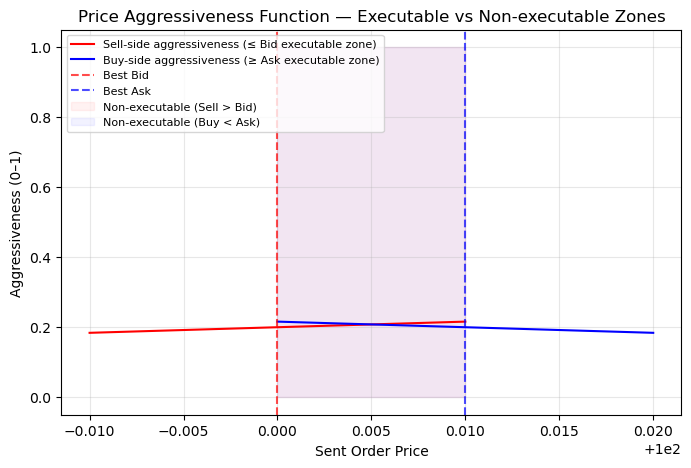

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
market_bid = 100.0
market_ask = 100.01
min_price_aggressiveness = 0.2
ca, cb = 1.005, 0.995

# --- Price ranges for sell and buy sides ---
sell_prices = np.linspace(market_bid - 0.01, market_bid + 0.01, 200)
buy_prices  = np.linspace(market_ask - 0.01, market_ask + 0.01, 200)

# --- Aggressiveness formulas ---
def sell_side_aggr(p_sent):
    val = (((1 - min_price_aggressiveness) * p_sent) +
           (market_bid * ((min_price_aggressiveness * ca) - 1))) / (market_bid * (ca - 1))
    return np.clip(val, 0, 1.0)

def buy_side_aggr(p_sent):
    val = (((1 - min_price_aggressiveness) * p_sent) +
           (market_ask * ((min_price_aggressiveness * cb) - 1))) / (market_ask * (cb - 1))
    return np.clip(val, 0, 1.0)

# --- Compute curves ---
sell_aggr = sell_side_aggr(sell_prices)
buy_aggr  = buy_side_aggr(buy_prices)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(sell_prices, sell_aggr, color='red', label='Sell-side aggressiveness (≤ Bid executable zone)')
plt.plot(buy_prices,  buy_aggr,  color='blue', label='Buy-side aggressiveness (≥ Ask executable zone)')

# Highlight bid-ask region
plt.axvline(market_bid, color='red', linestyle='--', alpha=0.7, label='Best Bid')
plt.axvline(market_ask, color='blue', linestyle='--', alpha=0.7, label='Best Ask')

# Highlight zones
plt.fill_betweenx([0,1], market_bid, market_bid+0.01, color='red', alpha=0.05, label='Non-executable (Sell > Bid)')
plt.fill_betweenx([0,1], market_ask-0.01, market_ask, color='blue', alpha=0.05, label='Non-executable (Buy < Ask)')

plt.title("Price Aggressiveness Function — Executable vs Non-executable Zones")
plt.xlabel("Sent Order Price")
plt.ylabel("Aggressiveness (0–1)")
plt.legend(loc="upper left", fontsize=8)
plt.grid(alpha=0.3)
plt.show()

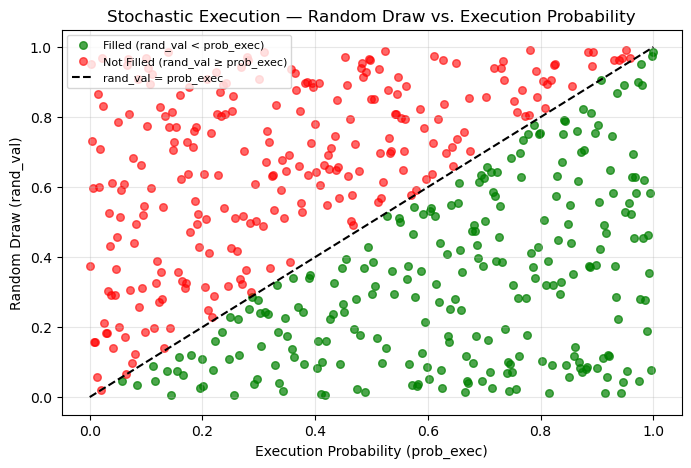

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
n_orders = 500
np.random.seed(42)

# Simulated execution probabilities (e.g., from price aggressiveness model)
prob_exec = np.linspace(0, 1, n_orders)

# Random draws (uniform [0,1])
rand_val = np.random.random(n_orders)

# Fill decision: order fills if random draw < prob_exec
filled = rand_val < prob_exec

# --- Plot ---
plt.figure(figsize=(8,5))
plt.scatter(prob_exec[filled], rand_val[filled],
            color='green', s=30, label='Filled (rand_val < prob_exec)', alpha=0.7)
plt.scatter(prob_exec[~filled], rand_val[~filled],
            color='red', s=30, label='Not Filled (rand_val ≥ prob_exec)', alpha=0.6)

# Reference line (rand = prob_exec boundary)
plt.plot([0,1],[0,1],'k--',label='rand_val = prob_exec')

plt.title("Stochastic Execution — Random Draw vs. Execution Probability")
plt.xlabel("Execution Probability (prob_exec)")
plt.ylabel("Random Draw (rand_val)")
plt.legend(loc='upper left', fontsize=8)
plt.grid(alpha=0.3)
plt.show()


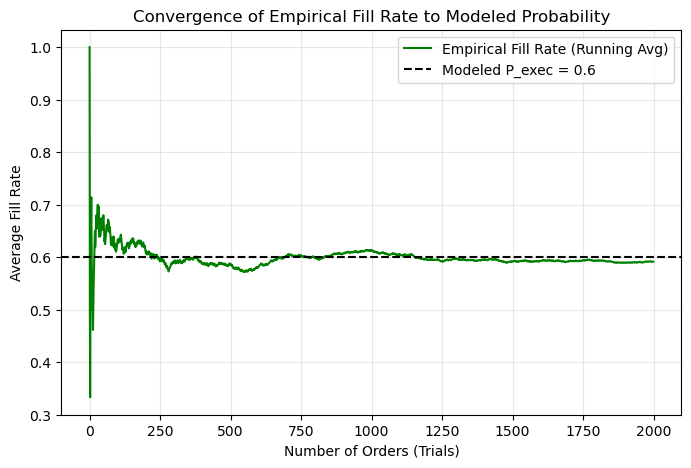

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
P_exec = 0.6              # Modeled execution probability
n_trials = 2000           # Number of simulated orders
np.random.seed(42)        # For reproducibility

# --- Bernoulli trials (fill decisions) ---
rand_vals = np.random.random(n_trials)
fills = (rand_vals < P_exec).astype(int)

# --- Compute running average (empirical fill rate) ---
running_avg = np.cumsum(fills) / np.arange(1, n_trials + 1)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(running_avg, label='Empirical Fill Rate (Running Avg)', color='green')
plt.axhline(P_exec, color='black', linestyle='--', label=f'Modeled P_exec = {P_exec}')
plt.xlabel('Number of Orders (Trials)')
plt.ylabel('Average Fill Rate')
plt.title('Convergence of Empirical Fill Rate to Modeled Probability')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
